In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import PredefinedSplit, GridSearchCV
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [2]:
# import data and do final prepare for tree models
data_file = os.path.join(os.getcwd(), 'data', 'oregon_washington_combined_data.pkl')
hospital_data = pd.read_pickle(data_file)
hospital_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7100 entries, 0 to 7099
Columns: 138 entries, Hospital_License_or_AHA to Pct_Inc_Total_Revenue_Next_Year
dtypes: float64(2), int64(133), object(3)
memory usage: 7.5+ MB


In [3]:
percent_missing = 100 * hospital_data['Pct_Inc_Total_Revenue_Next_Year'].isna().sum() / hospital_data.shape[0]
print(f'Rows with missing target: {percent_missing:.2f}%')

Rows with missing target: 20.46%


In [4]:
# remove rows with missing target or inf target
hospital_data = hospital_data.dropna()
hospital_data = hospital_data[~np.isinf(hospital_data['Pct_Inc_Total_Revenue_Next_Year'])]
hospital_data.info()
hospital_data = pd.concat([pd.get_dummies(hospital_data[['State', 'Quarter']].astype('category'), ['StateIs', 'IsQ']),
                           hospital_data], axis=1)
hospital_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5583 entries, 4 to 7095
Columns: 138 entries, Hospital_License_or_AHA to Pct_Inc_Total_Revenue_Next_Year
dtypes: float64(2), int64(133), object(3)
memory usage: 5.9+ MB


,StateIs_Oregon,StateIs_Washington,IsQ_1,IsQ_2,IsQ_3,IsQ_4,Hospital_License_or_AHA,Hospital_Name,Year,Quarter,...,Tax_Subsidies,Gross_Total_Margin,Gross_Accounts_Receivable_Medicare,Gross_Accounts_Receivable_Medicaid,Gross_Accounts_Receivable_Self_Pay,Gross_Accounts_Receivable_Other,Total_Gross_Accounts_Receivable,State,Next_Year_Total_Revenue,Pct_Inc_Total_Revenue_Next_Year
4,True,False,True,False,False,False,AHA_6920770,Adventist Health Columbia Gorge Medical Center,2008,1,...,0,1139743,21630299,5695074,12004199,22519231,61848803,Oregon,17964144.0,6.733211
5,True,False,False,True,False,False,AHA_6920770,Adventist Health Columbia Gorge Medical Center,2008,2,...,0,840605,20449150,7100382,13033639,21109840,61693011,Oregon,18008159.0,10.342272
6,True,False,False,False,True,False,AHA_6920770,Adventist Health Columbia Gorge Medical Center,2008,3,...,0,810174,22974244,6995167,11481375,20398974,61849760,Oregon,17420990.0,6.133349
8,True,False,True,False,False,False,AHA_6920770,Adventist Health Columbia Gorge Medical Center,2009,1,...,0,1284168,24412425,8685920,12818106,23220043,69136494,Oregon,18318848.0,1.974511
9,True,False,False,True,False,False,AHA_6920770,Adventist Health Columbia Gorge Medical Center,2009,2,...,0,1018971,22572577,7376929,13068397,21152727,64170630,Oregon,19193984.0,6.584932


In [5]:
validation_cutoff_year = 2022

test_data = hospital_data[hospital_data['Year'] >= validation_cutoff_year]
train_data = hospital_data[hospital_data['Year'] < validation_cutoff_year]
or_train_data = train_data[train_data['State'] == 'Oregon']
or_test_data = test_data[test_data['State'] == 'Oregon']
wa_train_data = train_data[train_data['State'] == 'Washington']
wa_test_data = test_data[test_data['State'] == 'Washington']


or_train_prop = 100 * or_train_data.shape[0] / train_data.shape[0]
or_test_prop = 100 * or_test_data.shape[0] / test_data.shape[0]
wa_train_prop = 100 * wa_train_data.shape[0] / train_data.shape[0]
wa_test_prop = 100 * wa_test_data.shape[0] / test_data.shape[0]
print(f'Training Pct of Overall: {100 * or_train_data.shape[0] / hospital_data.shape[0]:.2f}%')
print(f'Test Set Breakdown: (WA: {wa_test_prop:.2f}%)  (OR: {or_test_prop:.2f}%)')
print(f'Train Set Breakdown: (WA: {wa_train_prop:.2f}%)  (OR: {or_train_prop:.2f}%)')

train_x = train_data.drop(columns=['Hospital_License_or_AHA', 
                                   'Year', 'State', 'Quarter',
                                   'Hospital_Name',
                                   'Next_Year_Total_Revenue',
                                   'Pct_Inc_Total_Revenue_Next_Year'])
test_x = test_data.drop(columns=['Hospital_License_or_AHA', 
                                   'Year', 'State', 'Quarter',
                                   'Hospital_Name',
                                   'Next_Year_Total_Revenue',
                                   'Pct_Inc_Total_Revenue_Next_Year'])
train_y = train_data['Pct_Inc_Total_Revenue_Next_Year']
test_y = test_data['Pct_Inc_Total_Revenue_Next_Year']

Training Pct of Overall: 57.60%
Test Set Breakdown: (WA: 60.65%)  (OR: 39.35%)
Train Set Breakdown: (WA: 26.51%)  (OR: 73.49%)


In [6]:
np.isinf(train_y).sum()

np.int64(0)

### Tuning Boosted Model with CV score

In [7]:
# tuning boosted model with cv score
gbr_model = GradientBoostingRegressor(random_state=33)

param_grid = {
    'n_estimators': [10, 25, 50, 100, 200, 300, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=gbr_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=5,
    n_jobs=-1,  # use all cores
    verbose=1
)


grid_search.fit(train_x, train_y)

# print best parameters
print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
Best parameters: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 10}
Best CV score: -621.122683210102


{'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 10}
-621.122683210102


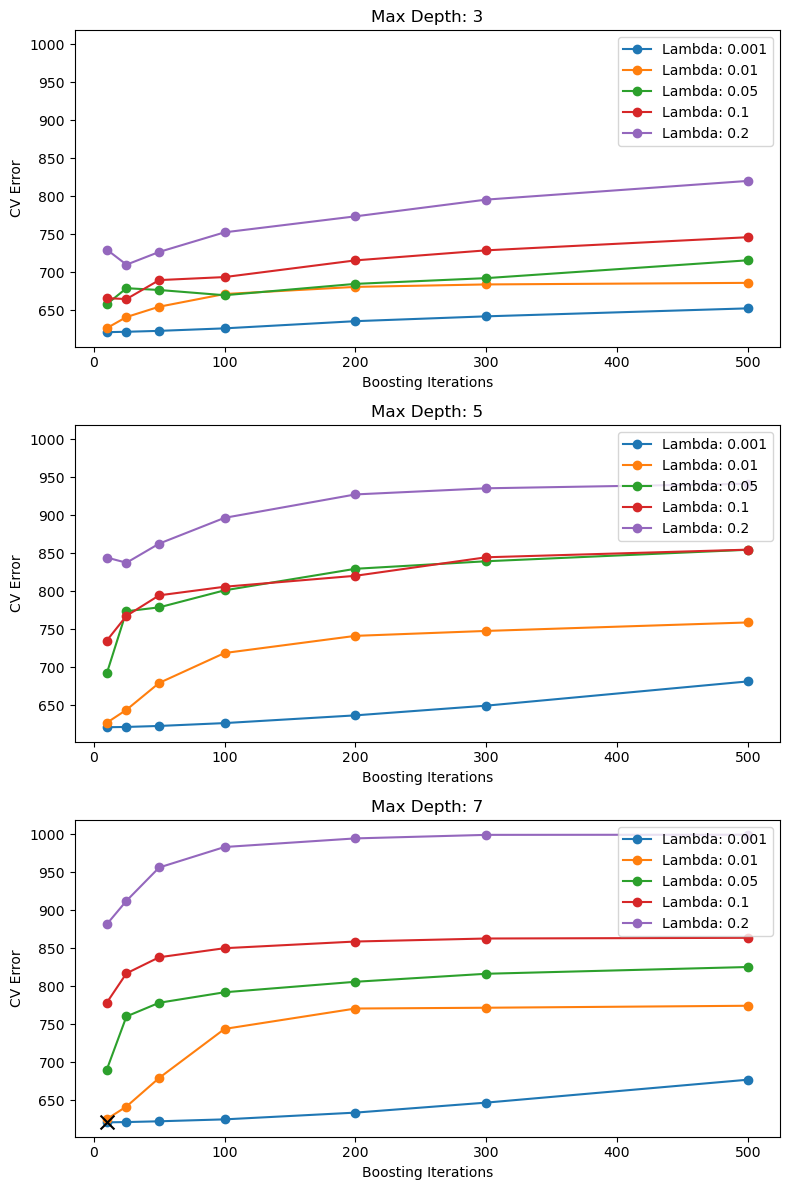

In [8]:
# plots
plot_dir = os.path.join(os.getcwd(), 'plots', 'tree_models')
data_dir = os.path.join(os.getcwd(), 'data', 'tree_models')

tune_results_df = pd.DataFrame(grid_search.cv_results_)

tune_results_df['max_depth']     = tune_results_df['param_max_depth'].astype(int)
tune_results_df['learning_rate'] = tune_results_df['param_learning_rate'].astype(float)
tune_results_df['n_estimators']  = tune_results_df['param_n_estimators'].astype(int)

# get mse from neg_mse
tune_results_df['cv_error'] = -tune_results_df['mean_test_score']

tune_results_df = tune_results_df[['max_depth', 'learning_rate', 'n_estimators', 'cv_error']]
tune_results_df.to_csv(os.path.join(data_dir, 'boosting_cv_tune_results.csv'), index=False)
tune_results_df.to_pickle(os.path.join(data_dir, 'boosting_cv_tune_results.pkl'))

depth_values = sorted(tune_results_df['max_depth'].unique())
lambda_values    = sorted(tune_results_df['learning_rate'].unique())

fig, axes = plt.subplots(nrows=len(depth_values), ncols=1, sharey=True, figsize=(8, 12))

for ax, depth in zip(axes, depth_values):
    df_depth = tune_results_df[tune_results_df['max_depth'] == depth]
    
    for learn_rate in lambda_values:
        # subset by learning rate lambda and sort by number of trees.
        df_lr = df_depth[df_depth['learning_rate'] == learn_rate].sort_values('n_estimators')
        ax.plot(df_lr['n_estimators'], df_lr['cv_error'], marker='o', label=f"Lambda: {learn_rate}")

    if depth == grid_search.best_params_['max_depth']:
        print(grid_search.best_params_)
        print(grid_search.best_score_)
        ax.scatter(x=[grid_search.best_params_['n_estimators']], y=[-grid_search.best_score_],
                   marker='x', color='black', s=100, zorder=1000)
    
    ax.set_title(f"Max Depth: {depth}")
    ax.set_xlabel("Boosting Iterations")
    ax.set_ylabel("CV Error")
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'boosting_cv_tune_results.png'))
plt.show()

In [10]:
# final model evaluation

# list for saving dictionaries of each model evaluation
model_evals = []

sklearn_gbr_model = grid_search.best_estimator_
sklearn_gbr_pred = sklearn_gbr_model.predict(test_x)
test_mse = mean_squared_error(test_y, sklearn_gbr_pred)
test_r2 = r2_score(test_y, sklearn_gbr_pred)
print(f'Sklearn GBR MSE (test): {test_mse}')
print(f'R-squared (test): {test_r2}')

sklearn_gbr_pred_train = sklearn_gbr_model.predict(train_x)
train_mse = mean_squared_error(train_y, sklearn_gbr_pred_train)
train_r2 = r2_score(train_y, sklearn_gbr_pred_train)
print(f'Sklearn GBR MSE (train): {train_mse}')
print(f'R-squared (train): {train_r2}')

same_sign = ((sklearn_gbr_pred * test_y) > 0)
pct_same_sign = np.sum(same_sign) / same_sign.shape[0]
pct_positive = np.sum(sklearn_gbr_pred > 0) / sklearn_gbr_pred.shape[0]
print(f'Percent of predictions same sign as actual (test): {100 * pct_same_sign:.2f}%')
print(f'Percent positive predictions (test): {100 * pct_positive:.2f}%')

# get errors for oregon and wa individually
test_mse_or = mean_squared_error(test_y[test_x['StateIs_Oregon'] == True],
                                         sklearn_gbr_model.predict(test_x[test_x['StateIs_Oregon'] == True]))
test_mse_wa = mean_squared_error(test_y[test_x['StateIs_Washington'] == True],
                                         sklearn_gbr_model.predict(test_x[test_x['StateIs_Washington'] == True]))
print(f'Sklearm GBR MSE (test OR): {test_mse_or}')
print(f'Sklearn GBR MSE (test WA): {test_mse_wa}')

model_evals.append(
   {'Model_Name':'SKlearn Gradient Boosting Model',
    'Hyperparameters':grid_search.best_params_,
    'Features_Used':list(sklearn_gbr_model.feature_names_in_),
    'MSE_Test':test_mse,
    'MSE_Train':train_mse,
    'R2_Test':test_r2,
    'R2_Train':train_r2,
    'Pct_Correct_Sign_Test':pct_same_sign,
    'Pct_Positive_Sign_Test':pct_positive,
    'MSE_Test_Oregon':test_mse_or,
    'MSE_Test_Washington':test_mse_wa}
)

Sklearn GBR MSE (test): 16027.64383168892
R-squared (test): -0.005815663891000966
Sklearn GBR MSE (train): 616.9183744302605
R-squared (train): 0.005557190814427626
Percent of predictions same sign as actual (test): 83.93%
Percent positive predictions (test): 100.00%
Sklearm GBR MSE (test OR): 286.31283185663756
Sklearn GBR MSE (test WA): 26242.30534114293


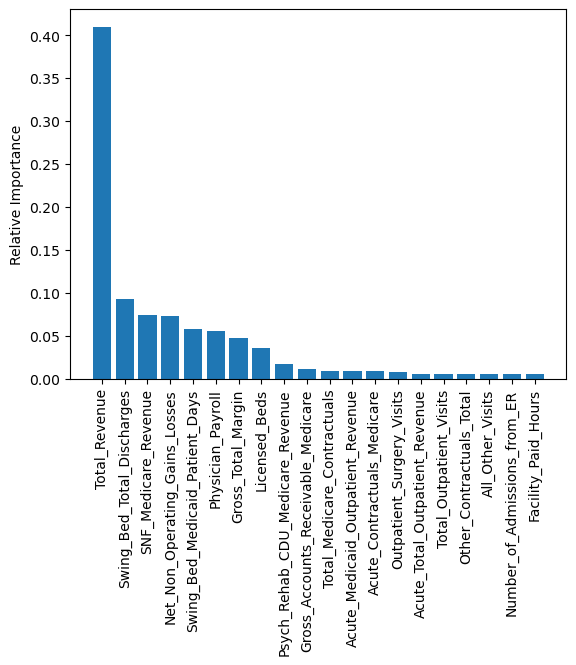

In [11]:
importances = sklearn_gbr_model.feature_importances_
feature_names = sklearn_gbr_model.feature_names_in_
indices = np.argsort(importances)[::-1][:20] # take top 20
sklearn_top_20 = np.array(feature_names).astype(str)[indices]
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), sklearn_top_20, rotation=90)
plt.ylabel('Relative Importance')
plt.show()

In [12]:
# What is the mse of a model that just assumes normal distribution of the target and randomly guesses?

np.random.seed(33)
guess_model = np.random.normal(np.mean(test_y), np.std(test_y), test_y.shape[0])

print(f'Guessing (normal) MSE: {mean_squared_error(test_y, guess_model)}')
print(f'Guessing R-squared: {r2_score(test_y, guess_model)}')

guess_model = np.random.lognormal(np.mean(np.log(test_y+np.abs(np.min(test_y))+0.00001)),
                                  np.std(np.log(test_y+np.abs(np.min(test_y))+0.00001)),
                                  test_y.shape[0])\
                                      - np.abs(np.min(test_y)) - 0.00001

print(f'Guessing (lognormal) MSE: {mean_squared_error(test_y, guess_model)}')
print(f'Guessing R-squared: {r2_score(test_y, guess_model)}')

# guessing the mean
y_mean = np.mean(train_y)
mean_guess_model = np.full_like(test_y, y_mean)
print(f'Guessing (mean) MSE: {mean_squared_error(test_y, mean_guess_model)}')
print(f'Guessing R-squared: {r2_score(test_y, mean_guess_model)}')


Guessing (normal) MSE: 28525.217654342476
Guessing R-squared: -0.7901015915958522
Guessing (lognormal) MSE: 21167.765364686788
Guessing R-squared: -0.3283842713846883
Guessing (mean) MSE: 16063.681429704711
Guessing R-squared: -0.008077205322413628


In [13]:
np.max(np.concat([train_y, test_y]))

np.float64(3858.525880791506)

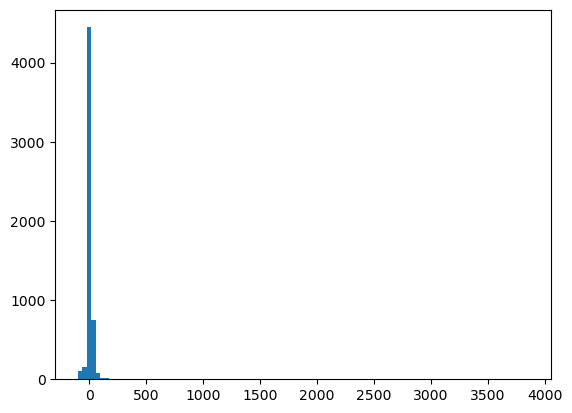

In [14]:
plt.hist(np.concat([train_y, test_y]), bins=100)
plt.show()

### Tuning boosted model with predefined tuning validation set

### XGBoost

In [15]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree',
                             tree_method='exact', random_state=33)

search_space = {
    'max_depth': (3, 10),
    'min_child_weight': (1, 10),
    'gamma': (0.0, 0.5, 'uniform'),
    'learning_rate': (0.001, 0.3, 'uniform'),
    'n_estimators': (10, 300),
    'reg_alpha': (0, 10, 'uniform')
}

bayes_search = BayesSearchCV(
    estimator=model_xgb,
    search_spaces=search_space,
    n_iter=120,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=33,
    verbose=1
)

bayes_search.fit(train_x, train_y)
print("Best parameters from Bayesian search:", bayes_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [17]:
# final model evaluation
model_xgb_best = bayes_search.best_estimator_
xgb_pred = model_xgb_best.predict(test_x)
test_mse = mean_squared_error(test_y, xgb_pred)
test_r2 = r2_score(test_y, xgb_pred)
print(f'XGBoost GBR MSE (test): {test_mse}')
print(f'R-squared (test): {test_r2}')

xgb_pred_train = model_xgb_best.predict(train_x)
train_mse = mean_squared_error(train_y, xgb_pred_train)
train_r2 = r2_score(train_y, xgb_pred_train)
print(f'XGBoost GBR MSE (train): {train_mse}')
print(f'R-squared (train): {train_r2}')

same_sign = ((xgb_pred * test_y) > 0)
pct_same_sign = np.sum(same_sign) / same_sign.shape[0]
pct_positive = np.sum(xgb_pred > 0) / xgb_pred.shape[0]
print(f'Percent of predictions same sign as actual (test): {100 * pct_same_sign:.2f}%')
print(f'Percent positive predictions (test): {100 * pct_positive:.2f}%')

# get errors for oregon and wa individually
test_mse_or = mean_squared_error(test_y[test_x['StateIs_Oregon'] == True],
                                         model_xgb_best.predict(test_x[test_x['StateIs_Oregon'] == True]))
test_mse_wa = mean_squared_error(test_y[test_x['StateIs_Washington'] == True],
                                         model_xgb_best.predict(test_x[test_x['StateIs_Washington'] == True]))
print(f'Sklearm GBR MSE (test OR): {test_mse_or}')
print(f'Sklearn GBR MSE (test WA): {test_mse_wa}')

model_evals.append(
   {'Model_Name':'XGBoost_all_features_nonnormalized',
    'Hyperparameters':bayes_search.best_params_,
    'Features_Used':list(model_xgb_best.feature_names_in_),
    'MSE_Test':test_mse,
    'MSE_Train':train_mse,
    'R2_Test':test_r2,
    'R2_Train':train_r2,
    'Pct_Correct_Sign_Test':pct_same_sign,
    'Pct_Positive_Sign_Test':pct_positive,
    'MSE_Test_Oregon':test_mse_or,
    'MSE_Test_Washington':test_mse_wa}
)

XGBoost GBR MSE (test): 15869.603476271348
R-squared (test): 0.004102167243454913
XGBoost GBR MSE (train): 574.6400292680919
R-squared (train): 0.07370785397081747
Percent of predictions same sign as actual (test): 83.84%
Percent positive predictions (test): 98.84%
Sklearm GBR MSE (test OR): 280.22365478907756
Sklearn GBR MSE (test WA): 25985.662786659428


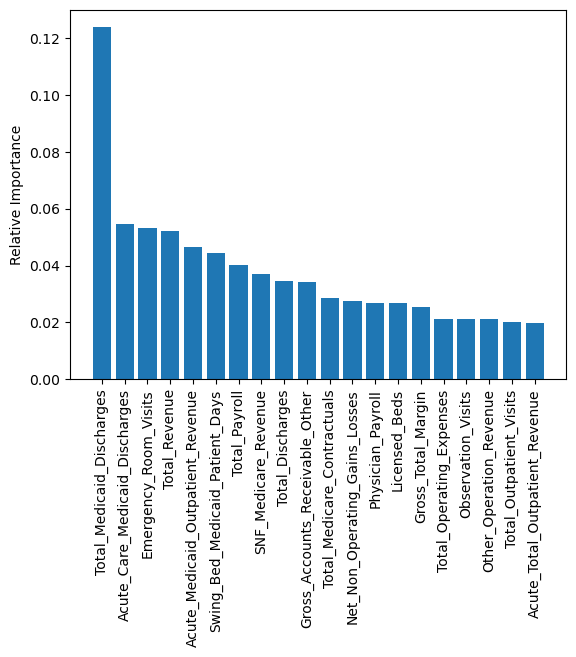

In [18]:
importances = model_xgb_best.feature_importances_
feature_names = model_xgb_best.feature_names_in_
indices = np.argsort(importances)[::-1][:20] # take top 20
xgb_top_20 = np.array(feature_names)[indices]
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), xgb_top_20, rotation=90)
plt.ylabel('Relative Importance')
plt.show()

In [19]:
top_20_union = list(map(str, list(set(xgb_top_20).union(set(sklearn_top_20)))))
top_20_intersection = list(map(str, list(set(xgb_top_20).intersection(set(sklearn_top_20)))))
print(len(top_20_intersection))
print(len(top_20_union))

top_10_union = list(map(str, list(set(xgb_top_20[:10]).union(set(sklearn_top_20[:10])))))
top_10_intersection = list(map(str, list(set(xgb_top_20[:10]).intersection(set(sklearn_top_20[:10])))))
print(len(top_10_intersection))
print(len(top_10_union))

11
29
3
17


In [20]:
# create within state normalized data

train_x_or = train_x[train_x['StateIs_Oregon'] == True]
train_y_or = train_y[train_x['StateIs_Oregon'] == True]
train_x_wa = train_x[train_x['StateIs_Washington'] == True]
train_y_wa = train_y[train_x['StateIs_Washington'] == True]

test_x_or = test_x[test_x['StateIs_Oregon'] == True]
test_y_or = test_y[test_x['StateIs_Oregon'] == True]
test_x_wa = test_x[test_x['StateIs_Washington'] == True]
test_y_wa = test_y[test_x['StateIs_Washington'] == True]

x_or = pd.concat([train_x_or, test_x_or], axis=0)
x_wa = pd.concat([train_x_wa, test_x_wa], axis=0)

y_or = pd.concat([train_y_or, test_y_or], axis=0)
y_wa = pd.concat([train_y_wa, test_y_wa], axis=0)

encoded_cols = ['StateIs_Oregon', 'StateIs_Washington', 'IsQ_1', 'IsQ_2', 'IsQ_3', 'IsQ_4']

normalizer = StandardScaler()

x_or = pd.concat([x_or[encoded_cols],
                  pd.DataFrame(normalizer.fit_transform(x_or.drop(columns=encoded_cols)),
                               columns=x_or.drop(columns=encoded_cols).columns,
                               index=x_or.index)],
                 axis=1
)
x_wa = pd.concat([x_wa[encoded_cols],
                  pd.DataFrame(normalizer.fit_transform(x_wa.drop(columns=encoded_cols)),
                               columns=x_wa.drop(columns=encoded_cols).columns,
                               index=x_wa.index)],
                 axis=1
)


train_x_state_normalized = pd.concat([x_or.loc[train_x_or.index], x_wa.loc[train_x_wa.index]], axis=0)
test_x_state_normalized = pd.concat([x_or.loc[test_x_or.index], x_wa.loc[test_x_wa.index]], axis=0)

# use these to unstransform predictions
y_or_std = np.std(y_or)
y_or_mean = np.mean(y_or)
y_wa_std = np.std(y_wa)
y_wa_mean = np.mean(y_wa)

y_or = (y_or - y_or_mean) / y_or_std
y_wa = (y_wa - y_wa_mean) / y_wa_std

train_y_state_normalized = pd.concat([y_or.loc[train_y_or.index], y_wa.loc[train_y_wa.index]], axis=0)
test_y_state_normalized = pd.concat([y_or.loc[test_y_or.index], y_wa.loc[test_y_wa.index]], axis=0)

In [21]:
model_xgb_norm_features = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree',
                             tree_method='exact', random_state=33)

search_space = {
    'max_depth': (3, 10),
    'min_child_weight': (1, 10),
    'gamma': (0.0, 0.5, 'uniform'),
    'learning_rate': (0.001, 0.3, 'uniform'),
    'n_estimators': (10, 300),
    'reg_alpha': (0, 10, 'uniform')
}

bayes_search_norm_features = BayesSearchCV(
    estimator=model_xgb_norm_features,
    search_spaces=search_space,
    n_iter=120,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=33,
    verbose=1,
    
)

bayes_search_norm_features.fit(train_x_state_normalized, train_y_state_normalized)
print("Best parameters from Bayesian search:", bayes_search_norm_features.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [22]:
model_xgb_norm_features = bayes_search_norm_features.best_estimator_
xgb_pred_norm_features = model_xgb_norm_features.predict(test_x_state_normalized)
is_oregon = test_x_state_normalized['StateIs_Oregon'] == True
is_washington = test_x_state_normalized['StateIs_Washington'] == True
xgb_pred_norm_features[is_oregon] = (xgb_pred_norm_features[is_oregon] * y_or_std) + y_or_mean # reverse transform
xgb_pred_norm_features[is_washington] = (xgb_pred_norm_features[is_washington] * y_wa_std) + y_wa_mean
test_mse = mean_squared_error(test_y, xgb_pred_norm_features)
test_r2 = r2_score(test_y, xgb_pred_norm_features)
print(f'XGBoost MSE with State-Normalized features (test): {test_mse}')
print(f'R-squared (test): {test_r2}')

xgb_pred_train_norm_features  = model_xgb_norm_features.predict(train_x_state_normalized)
is_oregon = train_x_state_normalized['StateIs_Oregon'] == True
is_washington = train_x_state_normalized['StateIs_Washington'] == True
xgb_pred_train_norm_features[is_oregon] = (xgb_pred_train_norm_features[is_oregon] * y_or_std) + y_or_mean # reverse transform
xgb_pred_train_norm_features[is_washington] = (xgb_pred_train_norm_features[is_washington] * y_wa_std) + y_wa_mean
train_mse = mean_squared_error(train_y, xgb_pred_train_norm_features)
train_r2 = r2_score(train_y, xgb_pred_train_norm_features)
print(f'XGBoost MSE (train): {train_mse}')
print(f'R-squared (train): {train_r2}')

same_sign = ((xgb_pred_norm_features * test_y) > 0)
pct_same_sign = np.sum(same_sign) / same_sign.shape[0]
pct_positive = np.sum(xgb_pred_norm_features > 0) / xgb_pred_norm_features.shape[0]
print(f'Percent of predictions same sign as actual (test): {100 * pct_same_sign:.2f}%')
print(f'Percent positive predictions (test): {100 * pct_positive:.2f}%')

# get errors for oregon and wa individually
test_mse_or = mean_squared_error(test_y[test_x_state_normalized['StateIs_Oregon'] == True],
                                         model_xgb_norm_features.predict(test_x_state_normalized[test_x_state_normalized['StateIs_Oregon'] == True]))
test_mse_wa = mean_squared_error(test_y[test_x_state_normalized['StateIs_Washington'] == True],
                                         model_xgb_norm_features.predict(test_x_state_normalized[test_x_state_normalized['StateIs_Washington'] == True]))
print(f'XGBoost GBR MSE (test OR): {test_mse_or}')
print(f'XGBoost GBR MSE (test WA): {test_mse_wa}')

model_evals.append(
   {'Model_Name':'XGBoost_State_Normalized_Features',
    'Hyperparameters':bayes_search_norm_features.best_params_,
    'Features_Used':list(model_xgb_norm_features.feature_names_in_),
    'MSE_Test':test_mse,
    'MSE_Train':train_mse,
    'R2_Test':test_r2,
    'R2_Train':train_r2,
    'Pct_Correct_Sign_Test':pct_same_sign,
    'Pct_Positive_Sign_Test':pct_positive,
    'MSE_Test_Oregon':test_mse_or,
    'MSE_Test_Washington':test_mse_wa}
)

XGBoost MSE with State-Normalized features (test): 17122.08232198679
R-squared (test): -0.07449721111445329
XGBoost MSE (train): 698.8443528594804
R-squared (train): -0.12650355419040404
Percent of predictions same sign as actual (test): 68.43%
Percent positive predictions (test): 76.55%
XGBoost GBR MSE (test OR): 367.24637356982936
XGBoost GBR MSE (test WA): 26525.46315064767


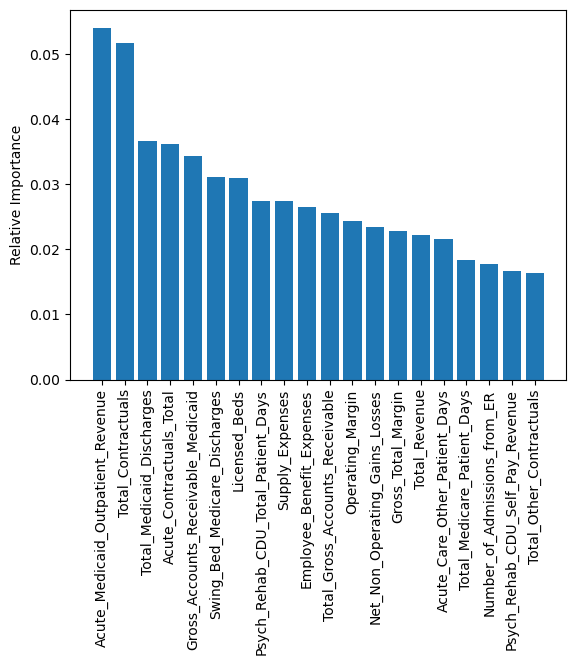

In [23]:
importances = model_xgb_norm_features.feature_importances_
feature_names = model_xgb_norm_features.feature_names_in_
indices = np.argsort(importances)[::-1][:20] # take top 20
xgb_top_20 = np.array(feature_names)[indices]
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), xgb_top_20, rotation=90)
plt.ylabel('Relative Importance')
plt.show()

### Ideas

- Limit features
- normalize target
- remove outliers
- train seperately on oregon and washington and compare
- do classification instead
- random forest instead of boosting

In [24]:
top_20_union = list(map(str, list(set(xgb_top_20).union(set(sklearn_top_20)))))
top_20_intersection = list(map(str, list(set(xgb_top_20).intersection(set(sklearn_top_20)))))
print(len(top_20_intersection))
print(top_20_intersection)
print(len(top_20_union))

top_10_union = list(map(str, list(set(xgb_top_20[:10]).union(set(sklearn_top_20[:10])))))
top_10_intersection = list(map(str, list(set(xgb_top_20[:10]).intersection(set(sklearn_top_20[:10])))))
print(len(top_10_intersection))
print(len(top_10_union))

6
['Acute_Medicaid_Outpatient_Revenue', 'Number_of_Admissions_from_ER', 'Net_Non_Operating_Gains_Losses', 'Gross_Total_Margin', 'Total_Revenue', 'Licensed_Beds']
34
1
19


In [25]:
for col in train_x.columns:
    print(col)

StateIs_Oregon
StateIs_Washington
IsQ_1
IsQ_2
IsQ_3
IsQ_4
Licensed_Beds
Acute_Care_Medicare_Discharges
Acute_Care_Medicaid_Discharges
Acute_Care_Self_Pay_Discharges
Acute_Care_Other_Discharges
Acute_Care_Total_Discharges
Swing_Bed_Medicare_Discharges
Swing_Bed_Medicaid_Discharges
Swing_Bed_Self_Pay_Discharges
Swing_Bed_Other_Discharges
Swing_Bed_Total_Discharges
SNF_Medicare_Discharges
SNF_Medicaid_Discharges
SNF_Self_Pay_Discharges
SNF_Other_Discharges
SNF_Total_Discharges
Psych_Rehab_CDU_Medicare_Discharges
Psych_Rehab_CDU_Medicaid_Discharges
Psych_Rehab_CDU_Self_Pay_Discharges
Psych_Rehab_CDU_Other_Discharges
Psych_Rehab_CDU_Total_Discharges
Total_Medicare_Discharges
Total_Medicaid_Discharges
Total_Self_Pay_Discharges
Total_Other_Discharges
Total_Discharges
Acute_Care_Medicare_Patient_Days
Acute_Care_Medicaid_Patient_Days
Acute_Care_Self_Pay_Patient_Days
Acute_Care_Other_Patient_Days
Acute_Care_Total_Patient_Days
Swing_Bed_Medicare_Patient_Days
Swing_Bed_Medicaid_Patient_Days
Swing_

### Subset the features

In [26]:
zero_pcts = train_x.apply(lambda s: np.isclose(s, 0)).sum(axis=0) / train_x.shape[0]

pct_0_thresh = 0.4
chosen_features = zero_pcts.index[zero_pcts < pct_0_thresh]
for feature in chosen_features:
    print(f'{feature} % zero: {100 * zero_pcts[feature]:.3f}%')
print(f'{chosen_features.shape[0]}/{zero_pcts.shape[0]} features have less than {100*pct_0_thresh:.0f}% zero values.')
chosen_features = list(set(chosen_features.to_list() + ['StateIs_Washington', 'StateIs_Oregon'] + [f'IsQ_{q}' for q in range(1,5)] + top_20_union).difference(set(['Quarter'])))
print(len(chosen_features))

StateIs_Oregon % zero: 26.508%
Licensed_Beds % zero: 0.137%
Acute_Care_Medicare_Discharges % zero: 2.902%
Acute_Care_Medicaid_Discharges % zero: 3.451%
Acute_Care_Self_Pay_Discharges % zero: 33.821%
Acute_Care_Other_Discharges % zero: 2.948%
Acute_Care_Total_Discharges % zero: 1.325%
Total_Medicare_Discharges % zero: 1.371%
Total_Medicaid_Discharges % zero: 1.622%
Total_Self_Pay_Discharges % zero: 32.610%
Total_Other_Discharges % zero: 1.280%
Total_Discharges % zero: 0.069%
Acute_Care_Medicare_Patient_Days % zero: 3.154%
Acute_Care_Medicaid_Patient_Days % zero: 3.519%
Acute_Care_Self_Pay_Patient_Days % zero: 33.341%
Acute_Care_Other_Patient_Days % zero: 2.765%
Acute_Care_Total_Patient_Days % zero: 1.371%
Total_Medicare_Patient_Days % zero: 1.622%
Total_Medicaid_Patient_Days % zero: 1.325%
Total_Self_Pay_Patient_Days % zero: 31.604%
Total_Other_Patient_Days % zero: 1.051%
Total_Patient_Days % zero: 0.069%
Total_Inpatient_Surgeries % zero: 13.140%
Total_Births % zero: 23.149%
Total_Newbo

In [27]:
x_train_subset = train_x[chosen_features].copy()
x_test_subset = test_x[chosen_features].copy()

In [28]:
model_xgb_subset_features = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree',
                             tree_method='exact', random_state=33)

search_space = {
    'max_depth': (3, 10),
    'min_child_weight': (1, 10),
    'gamma': (0.0, 0.5, 'uniform'),
    'learning_rate': (0.001, 0.3, 'uniform'),
    'n_estimators': (10, 300),
    'reg_alpha': (0, 10, 'uniform')
}

bayes_search_subset_features = BayesSearchCV(
    estimator=model_xgb_subset_features,
    search_spaces=search_space,
    n_iter=120,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=33,
    verbose=1,
    
)

bayes_search_subset_features.fit(x_train_subset, train_y)
print("Best parameters from Bayesian search:", bayes_search_subset_features.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [29]:
model_xgb_subset_features = bayes_search_subset_features.best_estimator_
xgb_pred_subset_features = model_xgb_subset_features.predict(x_test_subset)
test_mse = mean_squared_error(test_y, xgb_pred_subset_features)
test_r2 = r2_score(test_y, xgb_pred_subset_features)
print(f'XGBoost with subsetted features MSE (test): {test_mse}')
print(f'R-squared (test): {test_r2}')

xgb_pred_train_subset_features = model_xgb_subset_features.predict(x_train_subset)
train_mse = mean_squared_error(train_y, xgb_pred_train_subset_features)
train_r2 = r2_score(train_y, xgb_pred_train_subset_features)
print(f'XGBoost MSE (train): {train_mse}')
print(f'R-squared (train): {train_r2}')

same_sign = ((xgb_pred_subset_features * test_y) > 0)
pct_same_sign = np.sum(same_sign) / same_sign.shape[0]
pct_positive = np.sum(xgb_pred_subset_features > 0) / xgb_pred_subset_features.shape[0]
print(f'Percent of predictions same sign as actual (test): {100 * pct_same_sign:.2f}%')
print(f'Percent positive predictions (test): {100 * pct_positive:.2f}%')

# get errors for oregon and wa individually
test_mse_or = mean_squared_error(test_y[x_test_subset['StateIs_Oregon'] == True],
                                         model_xgb_subset_features.predict(x_test_subset[x_test_subset['StateIs_Oregon'] == True]))
test_mse_wa = mean_squared_error(test_y[x_test_subset['StateIs_Washington'] == True],
                                         model_xgb_subset_features.predict(x_test_subset[x_test_subset['StateIs_Washington'] == True]))
print(f'XGBoost GBR MSE (test OR): {test_mse_or}')
print(f'XGBoost GBR MSE (test WA): {test_mse_wa}')

model_evals.append(
   {'Model_Name':'XGBoost_Selected_Features',
    'Hyperparameters':bayes_search_subset_features.best_params_,
    'Features_Used':chosen_features,
    'MSE_Test':test_mse,
    'MSE_Train':train_mse,
    'R2_Test':test_r2,
    'R2_Train':train_r2,
    'Pct_Correct_Sign_Test':pct_same_sign,
    'Pct_Positive_Sign_Test':pct_positive,
    'MSE_Test_Oregon':test_mse_or,
    'MSE_Test_Washington':test_mse_wa}
)

XGBoost with subsetted features MSE (test): 15854.145204321658
R-squared (test): 0.0050722519437989
XGBoost MSE (train): 572.5459567433795
R-squared (train): 0.0770833983708955
Percent of predictions same sign as actual (test): 84.01%
Percent positive predictions (test): 99.17%
XGBoost GBR MSE (test OR): 279.7462758103387
XGBoost GBR MSE (test WA): 25960.483306839244


In [31]:
out_dir = os.path.join(os.getcwd(), 'data', 'tree_models')
pkl_path = os.path.join(out_dir, 'tree_model_comparison_metrics.pkl')
csv_path = os.path.join(out_dir, 'tree_model_comparison_metrics.csv')
model_evals_df = pd.DataFrame(data=model_evals, columns=model_evals[0].keys())
model_evals_df.to_pickle(pkl_path)
model_evals_df[['Hyperparameters', 'Features_Used']] = model_evals_df[['Hyperparameters', 'Features_Used']].map(lambda x: repr(x))
model_evals_df.to_csv(csv_path, index=False)
model_evals_df.head(1)

,Model_Name,Hyperparameters,Features_Used,MSE_Test,MSE_Train,R2_Test,R2_Train,Pct_Correct_Sign_Test,Pct_Positive_Sign_Test,MSE_Test_Oregon,MSE_Test_Washington
0,SKlearn Gradient Boosting Model,"{'learning_rate': 0.001, 'max_depth': 7, 'n_es...","['StateIs_Oregon', 'StateIs_Washington', 'IsQ_...",16027.643832,616.918374,-0.005816,0.005557,0.839271,1.0,286.312832,26242.305341
